In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import requests
from PIL import Image
from io import BytesIO

from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name

In [2]:
from time import sleep
import tqdm

In [158]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 469, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

# Bam Adebayo assists

In [153]:
from nba_api.stats.static.teams import find_teams_by_full_name

team_id = find_teams_by_full_name("Miami Heat")[0]['id']

team = ShotChartDetail(team_id=team_id, player_id=0, season_nullable='2019-20')

team_df = team.get_data_frames()[0]

player_id = find_players_by_full_name("Bam Adebayo")[0]['id']

team_df = team_df.loc[team_df.SHOT_MADE_FLAG == 1]

In [154]:
team_df = team_df.loc[team_df.PLAYER_ID != player_id]

team_df.LOC_X = -team_df.LOC_X

In [6]:
game_finder = LeagueGameFinder(player_id_nullable=player_id, player_or_team_abbreviation='P', season_nullable='2019-20')

games_df = game_finder.get_data_frames()[0]

unique_game_ids = games_df.GAME_ID.unique()

df = PlayByPlayV2(game_id=unique_game_ids[-1]).get_data_frames()[0]

In [7]:
assist_frames = []
for game_id in tqdm.tqdm(unique_game_ids):
    pbp_df = PlayByPlayV2(game_id=game_id).get_data_frames()[0]
    pbp_df = pbp_df.loc[(pbp_df.PLAYER2_ID == player_id) & (pbp_df.EVENTMSGTYPE == 1)]
    assist_frames.append(pbp_df)
    sleep(1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [03:02<00:00,  3.32s/it]


In [8]:
concated = pd.concat(assist_frames, ignore_index=True)

In [9]:
merged_df = pd.merge(left=team_df, right=concated, left_on=['GAME_ID', 'GAME_EVENT_ID'], right_on=['GAME_ID', 'EVENTNUM'], suffixes=('_shot', '_assist'))

In [10]:
created = [
    'Driving Dunk Shot',
    'Driving Finger Roll Layup Shot',
    'Driving Floating Bank Jump Shot',
    'Driving Floating Jump Shot',
    'Driving Hook Shot',
    'Driving Layup Shot',
    'Fadeaway Jump Shot',
    'Floating Jump shot',
    'Pullup Jump shot',
    'Step Back Jump shot',
    'Turnaround Fadeaway Bank Jump Shot',
    'Turnaround Hook Shot',
    'Turnaround Jump Shot'
]

non_created = [
    'Alley Oop Dunk Shot',
    'Alley Oop Layup shot',
    'Cutting Dunk Shot',
    'Cutting Finger Roll Layup Shot',
    'Cutting Layup Shot',
    'Dunk Shot',
    'Jump Bank Shot',
    'Jump Shot',
    'Layup Shot',
    'Hook Shot',
    'Reverse Dunk Shot',
    'Reverse Layup Shot',
    'Running Alley Oop Dunk Shot',
    'Running Alley Oop Layup Shot',
    'Running Dunk Shot',
    'Running Finger Roll Layup Shot',
    'Running Jump Shot',
    'Running Layup Shot',
    'Running Pull-Up Jump Shot',
    'Running Reverse Layup Shot',
]

In [255]:
def plot_raw_shotchart(data_frame, title, mode="dark", plot_fg_made = False, assist_df=None, image_name=None):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(12, 12))
    
    #made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    created_shots = data_frame.loc[data_frame.ACTION_TYPE.isin(created)]
    catch_and_shoot = data_frame.loc[data_frame.ACTION_TYPE.isin(non_created)]
    color = '#DB3EB1'
    
    paths = ax.scatter(
        x=data_frame.LOC_X,
        y=data_frame.LOC_Y,
        marker='o',
        c=color,
        edgecolors='white',
        linewidths=1,
        s=180,
        alpha=0.95,
    )
    
    
    if mode == 'dark':
        background_color="#000000"
        font_color="#E8E8FF"
    else:
        background_color="#EBEBE8"
        font_color = "#454545"
        
    if plot_fg_made:
        original_df = data_frame
        df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).sum()
        df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
        df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']).median()
        for index in range(len(df_by_zone_median)):
            loc_x = df_by_zone_median.iloc[index].LOC_X
            loc_y = df_by_zone_median.iloc[index].LOC_Y
            zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
            zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
            zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
            ax.text(x=loc_x, y=loc_y, s=f"{int(zone_shots_made)} FGM", va='bottom', ha='center', c='white',
                   bbox={'facecolor': '#565656', 'alpha': 0.75, 'edgecolor': '#DEDEDE', 'pad': 2})
    
    # Changing court color
    ax.set_facecolor('#000000')
    fig.set_facecolor('#000000')
    
    # Legend
    
    # Removing ticks
    #ax.xaxis.set_ticks([])
    #ax.yaxis.set_ticks([])
    #ax.grid(True)

    # Title
    ax.set_title(title, size=26, color='#41B6E6')
    
    team_id = data_frame.iloc[0].TEAM_ID
    player_id = data_frame.iloc[0].PLAYER2_ID
    url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2019/260x190/{player_id}.png"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    #ax.imshow(img, extent=(131, 251, -48, 40))
    ax.imshow(img, extent=(-220, -100, -48, 40))
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, color='#41B6E6', lw=4)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,423)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    
    #ax.legend(loc='upper right')
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')
    

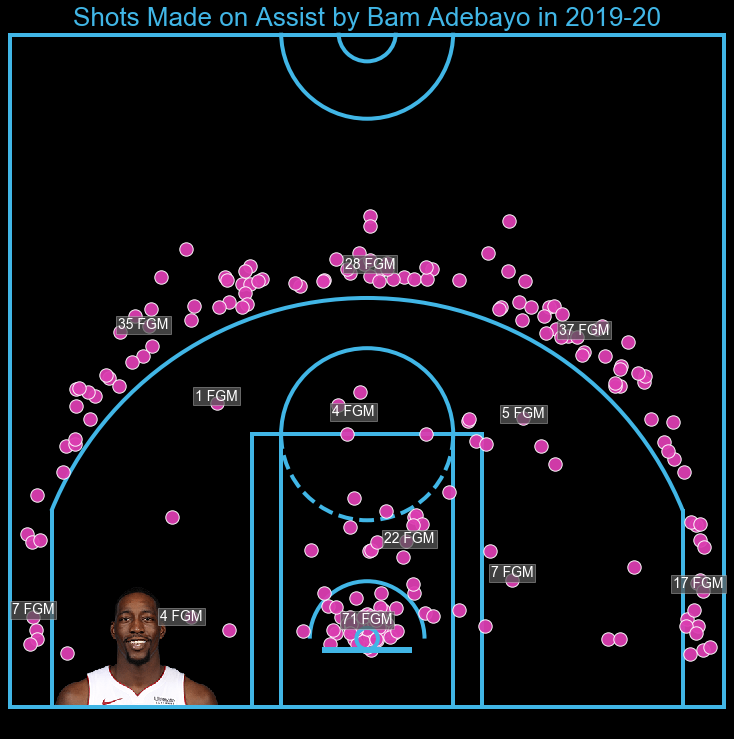

In [256]:
plot_raw_shotchart(data_frame=merged_df, title='Shots Made on Assist by Bam Adebayo in 2019-20', mode='dark', plot_fg_made=True)